In [1]:
import time
import re
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

from selenium import webdriver
from selenium.common.exceptions import TimeoutException
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.support.ui import WebDriverWait # available since 2.4.0
from selenium.webdriver.support import expected_conditions as EC # available since 2.26.0
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from sklearn.preprocessing import StandardScaler

from secrets import *

In [2]:
email = AUTH["email"]
password = AUTH["password"]

## LOGIN

In [3]:
# https://stackoverflow.com/questions/33326459/logging-into-espn-using-selenium

In [83]:
driver = webdriver.Chrome()

In [84]:
driver.get("http://games.espn.go.com/ffl/signin")

In [85]:
w = WebDriverWait(driver,1000).until(EC.presence_of_all_elements_located((By.XPATH,"(//iframe)")))

In [86]:
driver.switch_to_frame("disneyid-iframe")
time.sleep(2)

/Users/codyschank/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: use driver.switch_to.frame instead
  """Entry point for launching an IPython kernel.


In [87]:
driver.find_element_by_css_selector('input[type=email]').send_keys(email)

In [88]:
driver.find_element_by_css_selector('input[type=password]').send_keys(password)

In [89]:
driver.find_element_by_xpath("//button").click()

## STATS

In [50]:
leagueID = "84057"
url = "http://fantasy.espn.com/basketball/players/add?leagueId="+leagueID+"&view=stats"
url

'http://fantasy.espn.com/basketball/players/add?leagueId=84057&view=stats'

In [51]:
driver.get(url)

In [52]:
# show all players
driver.find_element_by_xpath("//*[@id='filterStatus']/option[1]").click()

In [53]:
# show totals
driver.find_element_by_xpath("//*[@id='espn-analytics']/div/div[5]/div[2]/div[2]/div/div/div[1]/div/div[3]/label[1]/div").click()

In [54]:
xpath = '//*[@id="espn-analytics"]/div/div[5]/div[2]/div[2]/div/div/div[2]/section/table/tbody'
table = driver.find_element_by_xpath(xpath)

In [55]:
cells = table.text.split('\n')

In [56]:
nba_teams = ['Hou','Mil','No','GS','LAL','OKC','Phi','Min','Por','Ind','Tor','Den','Bos','SA','Wsh','Utah','Cle','Det',
            'Cha','Phx','Dal','Mem','LAC','Mia','Atl','NY','Orl','Chi','Sac','Bkn']

In [67]:
# clean out unnecessary/ complicating data
cells = [i for i in cells if i not in ['O','DTD']]
cells = [i for i in cells if i not in nba_teams]
cells = [i for i in cells if '@' not in i]
cells = [i for i in cells if ':' not in i]
players = cells[6:156]
stats = cells[(cells.index('+/-')+1):] # find '+/-', and start from the cell after that?

In [68]:
players = [i for i in players if '--' not in i]

In [70]:
columns = ['player','position','fantasy_team','min','fgm/fga','fg%','ftm/fta','ft%','3pm','reb','ast','stl','blk','pts','pr5','own','change']
statsTable = pd.DataFrame()

In [71]:
j = 0
k = 0
for i in range(50):
    player = players[j:j+3]
    j = j+3
    player_stats = stats[k:k+14]
    k = k+14
    values = player+player_stats
    row = dict(zip(columns, values))
    statsTable = statsTable.append(row, ignore_index=True)

In [82]:
# this is another way to do it, with less cleanging post scraprin, but hits that page many more times, and thus flags the account
'''for i in range(1,51):
    xpath = '//*[@id="espn-analytics"]/div/div[5]/div[2]/div[2]/div/div/div[2]/section/table/tbody/tr/td[1]/table/tbody/tr[' + str(i) + ']/td[1]'
    playername = driver.find_element_by_xpath(xpath)
    playername = playername.text.split('\n')
    playername = [j for j in playername if j not in ['O','DTD']]
    xpath = '//*[@id="espn-analytics"]/div/div[5]/div[2]/div[2]/div/div/div[2]/section/table/tbody/tr/td[1]/table/tbody/tr[' + str(i) + ']/td[2]'
    fantasyteam = driver.find_element_by_xpath(xpath)
    fantasyteam = fantasyteam.text.split('\n')
    xpath = '//*[@id="espn-analytics"]/div/div[5]/div[2]/div[2]/div/div/div[2]/section/table/tbody/tr/td[2]/div/div/div[2]/table/tbody/tr/td/table/tbody/tr[' + str(i) + ']'
    stats = driver.find_element_by_xpath(xpath)
    stats = stats.text.split('\n')
    values = playername+fantasyteam+stats
    row = dict(zip(columns, values))
    statsTable = statsTable.append(row, ignore_index=True)
''' and None

In [82]:
statsTable.head(50)

,3pm,ast,blk,fantasy_team,fg%,ft%,min,player,position,pts,reb,stl,fta,fga
0,0,13,2.0,DEKK,.477,0.600,67,Giannis Antetokounmpo,"PF, SF",51.00,33,2.00,15,44
1,1,14,5.0,DOIS,.636,0.737,66,Anthony Davis,"PF, C",57.00,26,5.00,19,33
2,1,11,1.0,BEB,.474,0.813,76,LeBron James,"SF, PF",50.00,17,3.00,16,38
3,12,29,2.0,Wood,.450,0.760,113,James Harden,"SG, PG",85.00,20,7.00,25,60
4,1,20,3.0,Cod,.462,0.923,117,Kevin Durant,"SF, PF",85.00,28,3.00,26,65
5,7,7,5.0,WILL,.469,0.933,91,Karl-Anthony Towns,C,51.00,23,1.00,15,32
6,16,23,0.0,gov,.507,0.900,113,Stephen Curry,PG,93.00,16,3.00,10,67
7,4,8,6.0,Wood,.508,0.826,104,Joel Embiid,C,85.00,32,2.00,23,61
8,5,13,1.0,Cod,.500,1.000,65,Damian Lillard,PG,57.00,8,1.00,16,36
9,1,8,0.0,PREZ,.565,0.455,35,Russell Westbrook,PG,32.00,12,0.00,11,23


In [78]:
statsTable.shape

(250, 17)

In [74]:
for i in range(2,6):
    next_page = "//*[@id='espn-analytics']/div/div[5]/div[2]/div[2]/div/div/div[2]/div/div/ul/li["+str(i)+"]"
    driver.find_element_by_xpath(next_page).click()
    time.sleep(4)
    xpath = '//*[@id="espn-analytics"]/div/div[5]/div[2]/div[2]/div/div/div[2]/section/table/tbody'
    table = driver.find_element_by_xpath(xpath)
    cells = table.text.split('\n')
    cells = [i for i in cells if i not in ['O','DTD']]
    cells = [i for i in cells if i not in nba_teams]
    cells = [i for i in cells if '@' not in i]
    cells = [i for i in cells if ':' not in i]
    players = cells[6:156]
    players = [i for i in players if '--' not in i]
    stats = cells[(cells.index('+/-')+1):] 
    j = 0
    k = 0
    for i in range(50):
        player = players[j:j+3]
        j = j+3
        player_stats = stats[k:k+14]
        k = k+14
        values = player+player_stats
        row = dict(zip(columns, values))
        statsTable = statsTable.append(row, ignore_index=True)

## ANALYZE

In [79]:
statsTable['fta'] = statsTable['ftm/fta'].str.split('/',expand=True)[1]
statsTable['fga'] = statsTable['fgm/fga'].str.split('/',expand=True)[1]
statsTable = statsTable.drop(columns = ['pr5','own','change','ftm/fta','fgm/fga'])

In [80]:
statsTable = statsTable.replace("--","0")

In [81]:
statsTable['ast'] = pd.to_numeric(statsTable['ast']) 
statsTable['blk'] = pd.to_numeric(statsTable['blk']) 
statsTable['reb'] = pd.to_numeric(statsTable['reb']) 
statsTable['pts'] = pd.to_numeric(statsTable['pts']) 
statsTable['stl'] = pd.to_numeric(statsTable['stl'])
statsTable['3pm'] = pd.to_numeric(statsTable['3pm'])
statsTable['ft%'] = pd.to_numeric(statsTable['ft%'])
statsTable['fg%'] = pd.to_numeric(statsTable['fg%'])
statsTable['fta'] = pd.to_numeric(statsTable['fta'])
statsTable['fga'] = pd.to_numeric(statsTable['fga'])

ValueError: Unable to parse string "17/18" at position 44

In [89]:
scaler = StandardScaler()

In [90]:
statsTable[['ast', 'blk','reb','pts','stl','3pm','ft%','fg%','fta','fga']] = scaler.fit_transform(statsTable[['ast', 'blk','reb','pts','stl','3pm','ft%','fg%','fta','fga']])

In [91]:
statsTable.head()

,3pm,ast,blk,fantasy_team,fg%,ft%,player,position,pts,reb,stl,fta,fga
0,-0.582731,1.829418,2.185778,DEKK,0.980343,0.110989,Giannis Antetokounmpo,"PF, SF",3.066670,2.332997,1.580595,3.562314,2.591411
1,-0.598583,-0.307453,4.536252,DOIS,0.716099,0.415334,Anthony Davis,"PF, C",2.808643,2.539074,2.038891,3.279260,2.477258
2,1.430447,1.273831,2.050694,Ingl,0.716099,0.957217,Kevin Durant,"SF, PF",2.320484,0.890455,-0.023439,1.925193,1.779657
3,2.746146,3.104418,0.078457,Wood,-0.172719,0.727102,James Harden,"SG, PG",2.903950,0.568773,1.842478,4.273773,2.195047
4,0.019637,0.169782,2.536998,Wood,0.415823,0.185220,Joel Embiid,C,1.895088,2.227445,-0.678146,2.751403,1.573548


In [92]:
statsTable['fga_adj'] = statsTable['fga'] + abs(statsTable['fga'].min())
statsTable['fta_adj'] = statsTable['fta'] + abs(statsTable['fta'].min())

In [93]:
statsTable['fg%_adj'] = statsTable['fg%'] * statsTable['fga_adj']
statsTable['ft%_adj'] = statsTable['ft%'] * statsTable['fta_adj']

In [94]:
statsTable[['fg%_adj','ft%_adj']] = scaler.fit_transform(statsTable[['fg%_adj','ft%_adj']])

In [95]:
statsTable = statsTable.drop(columns = ['fga_adj','fta_adj','fg%','ft%','fta','fga'])

In [96]:
statsTable['cumulative'] = statsTable['ft%_adj'] + statsTable['fg%_adj'] + statsTable['ast'] + statsTable['blk'] + statsTable['pts'] + statsTable['reb'] + statsTable['stl'] + statsTable['3pm']  

In [97]:
statsTable = statsTable.sort_values('cumulative',ascending=False)

In [121]:
statsTable.head()

,3pm,ast,blk,fantasy_team,player,position,pts,reb,stl,fg%_adj,ft%_adj,cumulative
1,-0.598583,-0.307453,4.536252,DOIS,Anthony Davis,"PF, C",2.808643,2.539074,2.038891,2.258000,1.360170,14.634993
0,-0.582731,1.829418,2.185778,DEKK,Giannis Antetokounmpo,"PF, SF",3.066670,2.332997,1.580595,3.229826,0.235687,13.878239
3,2.746146,3.104418,0.078457,Wood,James Harden,"SG, PG",2.903950,0.568773,1.842478,-0.718831,3.092478,13.617869
8,0.400080,-0.043906,1.915609,WILL,Karl-Anthony Towns,C,2.520397,3.252805,-0.088909,2.991641,1.686900,12.634618
10,3.649699,1.872155,-0.786085,gov,Stephen Curry,PG,2.313510,-0.074590,2.104361,0.795113,2.426145,12.300308


## My team

In [122]:
my_team = statsTable.loc[statsTable.fantasy_team == 'Ingl']

In [123]:
my_team

,3pm,ast,blk,fantasy_team,player,position,pts,reb,stl,fg%_adj,ft%_adj,cumulative
2,1.430447,1.273831,2.050694,Ingl,Kevin Durant,"SF, PF",2.320484,0.890455,-0.023439,1.914866,2.409279,12.266617
9,2.381555,2.064474,-0.569949,Ingl,Damian Lillard,PG,2.652897,-0.079616,0.271180,-0.948107,3.600038,9.372471
19,-1.391173,0.013078,2.212795,Ingl,Andre Drummond,C,0.914122,4.454085,1.646066,3.666905,-3.795195,7.720683
21,-0.757101,-0.186364,1.726490,Ingl,LaMarcus Aldridge,"PF, C",1.927632,1.624292,-0.481734,1.765636,1.197946,6.816798
69,1.747483,-0.407174,0.672830,Ingl,Jaylen Brown,SG,0.658419,0.267197,2.300774,0.247833,-0.565500,4.921862
119,1.652372,-0.321699,-0.542932,Ingl,Buddy Hield,SG,0.414340,-0.190194,0.336651,-0.675851,0.231892,0.904578
130,0.891486,0.468943,-0.542932,Ingl,Bogdan Bogdanovic,"SF, SG",0.128418,-0.391245,0.336651,-0.307035,0.288750,0.873036
78,-0.788804,-0.905777,-0.056627,Ingl,TJ Warren,SF,0.897850,-0.104748,0.271180,0.907374,-0.139269,0.081178
151,0.178155,-0.164995,-0.164695,Ingl,Kelly Olynyk,C,-0.283030,0.211908,-0.285322,0.427181,-0.200484,-0.281281
116,0.174985,-0.093766,-0.380831,Ingl,Jeremy Lamb,"SG, SF",0.065655,-0.371140,-0.514469,-0.196686,0.629666,-0.686586


In [124]:
my_team[['ast','blk','pts','reb','stl','3pm','ft%_adj','fg%_adj']].sum(axis=0)

ast        4.314371
blk        1.773824
pts        7.913789
reb        4.816379
stl        3.829254
3pm        4.250551
ft%_adj    3.516472
fg%_adj    5.151027
dtype: float64

In [125]:
opp_team =  statsTable.loc[statsTable.fantasy_team == 'gov']

In [126]:
opp_team
# Kyle O'Quinn not showing up...not scraped, too bad of a player?

,3pm,ast,blk,fantasy_team,player,position,pts,reb,stl,fg%_adj,ft%_adj,cumulative
10,3.649699,1.872155,-0.786085,gov,Stephen Curry,PG,2.313510,-0.074590,2.104361,0.795113,2.426145,12.300308
15,1.953556,1.074390,-0.353814,gov,Donovan Mitchell,SG,2.183335,-0.351035,1.777008,-0.577101,1.049928,6.756266
14,0.463488,1.174111,-0.759068,gov,DeMar DeRozan,"SG, SF",2.450660,-0.089669,0.631269,-0.103256,1.915275,5.682810
34,0.685413,0.205396,-0.569949,gov,Gordon Hayward,"SF, SG",1.034999,-0.124853,0.205709,-0.232711,1.129141,2.333144
102,-0.313251,0.582910,1.051067,gov,James Johnson,PF,-0.157503,0.025936,0.467592,0.522428,-0.569033,1.610146
72,-1.391173,-0.898654,0.888965,gov,Steven Adams,C,-0.050573,1.352873,0.533063,2.499254,-2.311560,0.622195
76,1.145115,-0.093766,-0.569949,gov,Carmelo Anthony,"PF, SF",0.477103,-0.029353,-0.514469,-0.199430,0.388819,0.604070
155,0.460317,-0.357313,-0.596966,gov,Mario Hezonja,SF,-0.027328,-0.029353,0.860417,-0.641571,0.393459,0.061661
136,-0.107177,0.632770,-0.786085,gov,Malcolm Brogdon,"SG, PG",-0.403907,-0.803400,0.467592,-0.087566,0.406809,-0.680964
88,0.130600,1.451904,-1.002220,gov,Reggie Jackson,PG,0.474779,-0.853663,-0.710882,-1.068523,0.822786,-0.755220


In [109]:
my_team[['ast','blk','pts','reb','stl','3pm','ft%_adj','fg%_adj']].sum(axis=0) - opp_team[['ast','blk','pts','reb','stl','3pm','ft%_adj','fg%_adj']].sum(axis=0)

ast       -1.724911
blk        5.292726
pts        0.942016
reb        5.876522
stl       -3.035094
3pm       -1.533839
ft%_adj   -1.598834
fg%_adj    6.474359
dtype: float64

In [ ]:
# rather than use PR, use stat averages, and num games played during the matchup.

## Some plots

In [ ]:
# 14 players on roster including IR, so let's focus on 12*14 = 168 players
# but there is a pool of free agents that people would consider adding. I think 250 could be a good number.

In [112]:
statsTable.iloc[168]

3pm                 -1.01073
ast                -0.820302
blk                  0.32161
fantasy_team              FA
player          Gorgui Dieng
position               C, PF
pts                -0.959479
reb                 0.191803
stl                 -0.15438
fg%_adj             0.285291
ft%_adj           -0.0243125
cumulative           -2.1705
Name: 230, dtype: object

/Users/codyschank/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
No handles with labels found to put in legend.


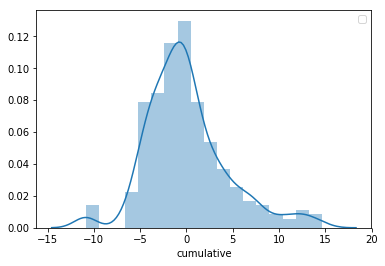

In [111]:
sns.distplot(statsTable.cumulative)
plt.legend()
plt.show()

/Users/codyschank/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
No handles with labels found to put in legend.


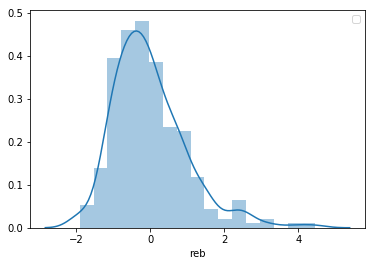

In [113]:
sns.distplot(statsTable.reb)
plt.legend()
plt.show()

/Users/codyschank/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
No handles with labels found to put in legend.


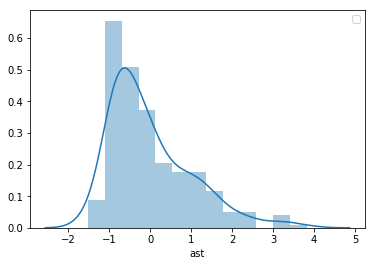

In [114]:
sns.distplot(statsTable.ast)
plt.legend()
plt.show()

/Users/codyschank/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
No handles with labels found to put in legend.


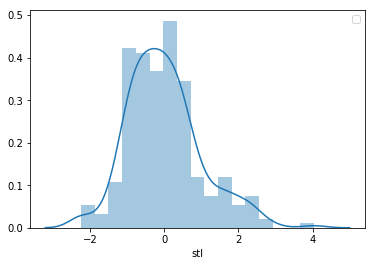

In [115]:
sns.distplot(statsTable.stl)
plt.legend()
plt.show()

/Users/codyschank/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
No handles with labels found to put in legend.


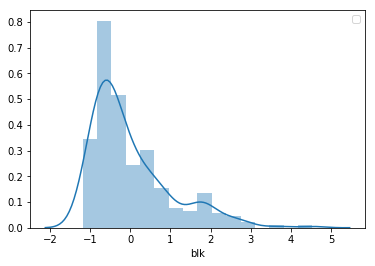

In [116]:
sns.distplot(statsTable.blk)
plt.legend()
plt.show()

/Users/codyschank/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
No handles with labels found to put in legend.


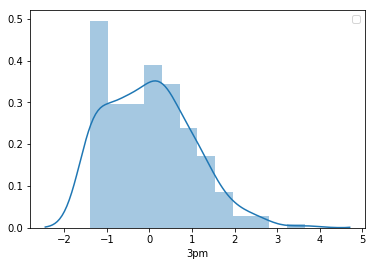

In [118]:
sns.distplot(statsTable['3pm'])
plt.legend()
plt.show()

/Users/codyschank/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
No handles with labels found to put in legend.


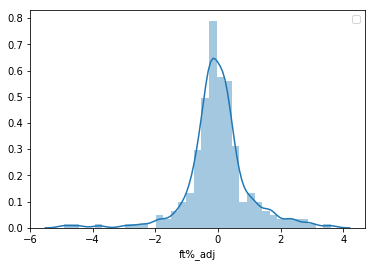

In [119]:
sns.distplot(statsTable['ft%_adj'])
plt.legend()
plt.show()

/Users/codyschank/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
No handles with labels found to put in legend.


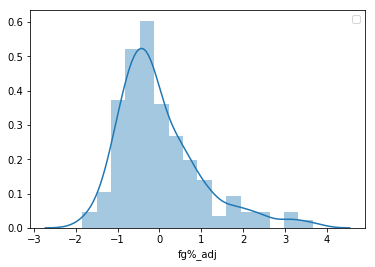

In [120]:
sns.distplot(statsTable['fg%_adj'])
plt.legend()
plt.show()